### Download and Unzip the dataset

In [30]:
# download the dataset via curl
!curl -L -o mpst-movie-plot-synopses-with-tags.zip https://www.kaggle.com/api/v1/datasets/download/cryptexcode/mpst-movie-plot-synopses-with-tags

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 29 28.7M   29 8542k    0     0  8582k      0  0:00:03 --:--:--  0:00:03 8582k
100 28.7M  100 28.7M    0     0  18.4M      0  0:00:01  0:00:01 --:--:-- 36.0M


In [ ]:
# unzip the dataset
!unzip mpst-movie-plot-synopses-with-tags.zip

In [18]:
#import packages for preprocessing and visualization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read the data using Pandas

In [19]:
#read the dataframe into a pandas object
movies_df = pd.read_csv('mpst-movie-plot-synopses-with-tags/mpst_full_data.csv')

In [20]:
movies_df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


### Visualizations

C:\Users\naman\AppData\Local\Temp\ipykernel_20312\1254670259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts[:15].index, y=tag_counts[:15].values, palette='coolwarm')


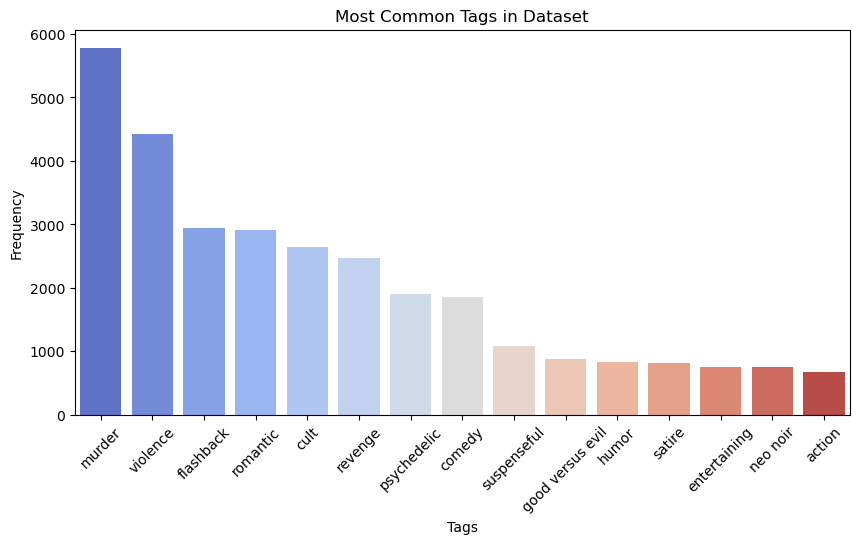

In [22]:
#plot the most common movie genres

tag_counts = movies_df['tags'].dropna().str.split(', ').explode().value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=tag_counts[:15].index, y=tag_counts[:15].values, palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Most Common Tags in Dataset')
plt.show()

C:\Users\naman\AppData\Local\Temp\ipykernel_20312\1533101746.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=movies_df['synopsis_source'], palette='pastel')


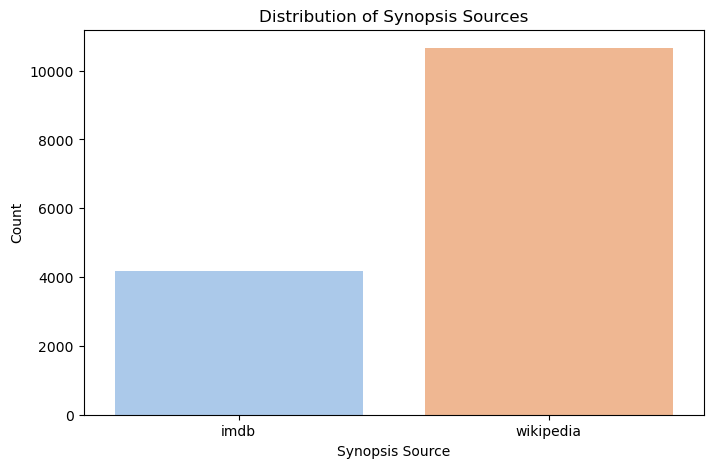

In [23]:
#plot the source of textual descriptions of movies

plt.figure(figsize=(8, 5))
sns.countplot(x=movies_df['synopsis_source'], palette='pastel')
plt.xlabel('Synopsis Source')
plt.ylabel('Count')
plt.title('Distribution of Synopsis Sources')
plt.show()

In [24]:
#concatenated plot synopsis with tags to augment the quality of data

movies_df['description_text'] = movies_df['plot_synopsis'] + " " + movies_df['tags']

In [25]:
df = movies_df[['title', 'description_text']]
df.dropna(inplace=True)

C:\Users\naman\AppData\Local\Temp\ipykernel_20312\1355535131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


### Text Preprocessing

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

#clean datasets to have only relevant and important words while similarity computation
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df["clean_summary"] = df["description_text"].apply(clean_text)

#create a tf-idf matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["clean_summary"])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\naman\AppData\Local\Temp\ipykernel_20312\3839655057.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_summary"] = df["description_text"].apply(clean_text)


### Save files for inference

In [27]:
#dump pickle files for inference

import pickle,os
if not os.path.exists('data'):
    os.mkdir('data')
with open('data/tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

with open('data/vec.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

### Recommend

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies(user_input, top_n=5):
    user_input_cleaned = clean_text(user_input)
    user_vec = vectorizer.transform([user_input_cleaned])
    
    similarity_scores = cosine_similarity(user_vec, tfidf_matrix).flatten()
    top_indices = similarity_scores.argsort()[-top_n:][::-1]
    
    recommendations = list(zip(df.iloc[top_indices]['title'].values, similarity_scores[top_indices]))

    print("\nUser Input:", user_input)
    print("\nTop Movie Recommendations:\n")
    for i, (title, score) in enumerate(recommendations, start=1):
        print(f"{i}. {title} (Similarity: {score:.4f})")

In [29]:
user_query = "I like action movies set in space."
recommend_movies(user_query)



User Input: I like action movies set in space.

Top Movie Recommendations:

1. Future War 198X (Similarity: 0.1171)
2. Gravity (Similarity: 0.1042)
3. The Right Stuff (Similarity: 0.1011)
4. Power Rangers Lost Galaxy (Similarity: 0.1004)
5. Duke Nukem 3D (Similarity: 0.0927)


Salary Expectations: >35$/hr